## 🧭 Prescriptive Analytics — Predictive Maintenance

**Goal:** Turn predictions into **actions** via simple, transparent decision rules and prioritization under capacity limits (what should we do?).

#### 📦 Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score

plt.rcParams['figure.figsize']=(7,4)
pd.set_option('display.max_columns',50)

#### 📥 Read Data

In [ ]:
df = pd.read_csv('data/PdM_data.csv')

df.head()

,asset_id,age,load_factor,ambient,temperature,vibration,pressure,current,fail_next_24h,rul_hours
0,0,175.027531,1.037522,28.639848,75.772244,0.777042,32.456836,15.351275,1,112.743486
1,0,176.027531,0.792100,24.400995,74.248343,0.786263,33.293140,12.791664,0,114.756578
2,0,177.027531,0.641573,28.776035,70.731868,0.752131,30.066905,10.782674,1,127.546885
3,0,178.027531,0.638114,25.154667,68.649198,0.672473,34.409435,10.587894,1,149.582275
4,0,179.027531,0.632052,36.919182,69.473329,0.667970,32.937247,12.690585,0,130.314500


#### ⚡ Train quick predictors

Classifier AUC (quick check): 0.744


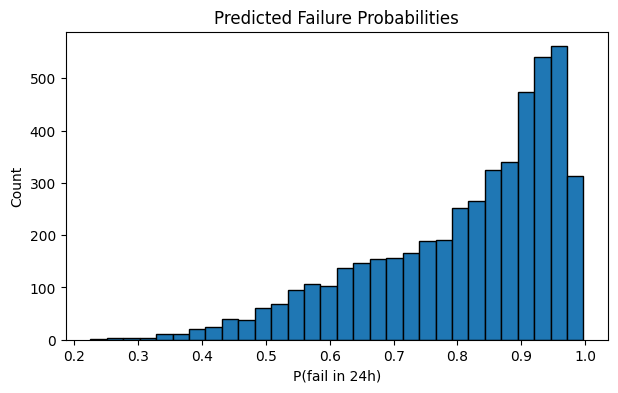

In [3]:
features=['age','load_factor','ambient','temperature','vibration','pressure','current']
X=df[features]; y=df['fail_next_24h']
Xtr,Xte,ytr,yte=train_test_split(X,y,test_size=0.25,random_state=518,stratify=y)
clf=Pipeline([('scaler',StandardScaler()),('rf',RandomForestClassifier(n_estimators=400,random_state=518))])
clf.fit(Xtr,ytr)
proba=clf.predict_proba(Xte)[:,1]  # P(fail in 24h)

# RUL model
yr=df['rul_hours']
Xr_tr,Xr_te,yr_tr,yr_te=train_test_split(X,yr,test_size=0.25,random_state=518)
rgr=Pipeline([('scaler',StandardScaler()),('gbr',GradientBoostingRegressor(random_state=518))])
rgr.fit(Xr_tr,yr_tr)
rul_hat=rgr.predict(Xr_te)
print('Classifier AUC (quick check):', round(roc_auc_score(yte, proba), 3))
plt.hist(proba,bins=30,edgecolor='black'); plt.title('Predicted Failure Probabilities'); plt.xlabel('P(fail in 24h)'); plt.ylabel('Count'); plt.show()

#### 🧮 Cost-Aware Policy
Let `C_maint` be planned maintenance cost and `C_fail` the cost of failure. **Policy:** if `risk * C_fail > C_maint`, do maintenance now. Otherwise, continue operation.

,age,load_factor,ambient,temperature,vibration,pressure,current,asset_id,p_fail_24h,exp_cost_if_wait,policy_action
10565,4944.442846,0.878332,23.600100,75.309294,1.576549,30.991181,16.738909,220,0.9925,7940.0,MAINTAIN_NOW
17521,2781.126955,0.748003,29.138688,73.940196,1.135875,33.146189,14.803572,365,0.9575,7660.0,MAINTAIN_NOW
3475,596.332908,0.799680,24.944424,69.679866,0.881802,30.693854,13.453522,72,0.6475,5180.0,MAINTAIN_NOW
10215,3364.273261,0.986437,18.175745,78.078814,1.298128,32.296344,16.427319,212,0.9325,7460.0,MAINTAIN_NOW
16507,724.846402,0.860427,22.269487,71.632608,0.851549,29.923736,13.821387,343,0.8500,6800.0,MAINTAIN_NOW


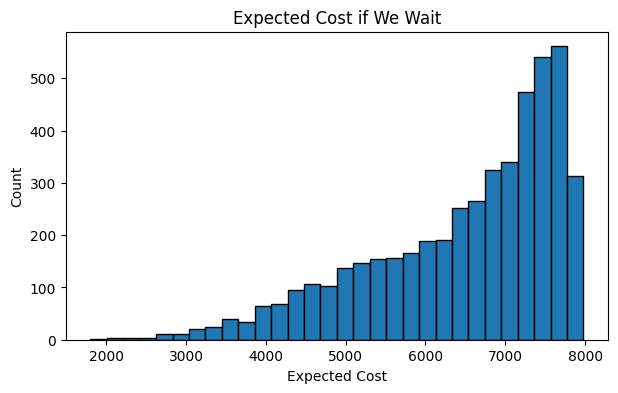

In [4]:
snap=Xte.copy()
snap['asset_id']=df.loc[Xte.index,'asset_id'].values
snap['p_fail_24h']=proba
C_maint=1000.0; C_fail=8000.0
snap['exp_cost_if_wait']=snap['p_fail_24h']*C_fail
snap['policy_action']=np.where(snap['exp_cost_if_wait']>C_maint,'MAINTAIN_NOW','CONTINUE')
display(snap.head())
plt.hist(snap['exp_cost_if_wait'],bins=30,edgecolor='black'); plt.title('Expected Cost if We Wait'); plt.xlabel('Expected Cost'); plt.ylabel('Count'); plt.show()

#### 🗂️ Prioritization Under Capacity
Assume we can service only **K** assets today. Prioritize by expected cost of waiting (descending).

In [5]:
capacity=10
priority=(snap.sort_values('exp_cost_if_wait',ascending=False)[['asset_id','p_fail_24h','exp_cost_if_wait','policy_action']].head(50))
display(priority.head(capacity))
maint_now=priority[priority['policy_action']=='MAINTAIN_NOW'].head(capacity)
print(f'Schedule maintenance for up to {capacity} assets:')
display(maint_now)

,asset_id,p_fail_24h,exp_cost_if_wait,policy_action
16010,333,0.9975,7980.0,MAINTAIN_NOW
16531,344,0.9950,7960.0,MAINTAIN_NOW
4209,87,0.9950,7960.0,MAINTAIN_NOW
10301,214,0.9950,7960.0,MAINTAIN_NOW
16211,337,0.9950,7960.0,MAINTAIN_NOW
10289,214,0.9950,7960.0,MAINTAIN_NOW
18088,376,0.9950,7960.0,MAINTAIN_NOW
11618,242,0.9950,7960.0,MAINTAIN_NOW
18886,393,0.9950,7960.0,MAINTAIN_NOW
16739,348,0.9950,7960.0,MAINTAIN_NOW


Schedule maintenance for up to 10 assets:


,asset_id,p_fail_24h,exp_cost_if_wait,policy_action
16010,333,0.9975,7980.0,MAINTAIN_NOW
16531,344,0.9950,7960.0,MAINTAIN_NOW
4209,87,0.9950,7960.0,MAINTAIN_NOW
10301,214,0.9950,7960.0,MAINTAIN_NOW
16211,337,0.9950,7960.0,MAINTAIN_NOW
10289,214,0.9950,7960.0,MAINTAIN_NOW
18088,376,0.9950,7960.0,MAINTAIN_NOW
11618,242,0.9950,7960.0,MAINTAIN_NOW
18886,393,0.9950,7960.0,MAINTAIN_NOW
16739,348,0.9950,7960.0,MAINTAIN_NOW


#### 🧾 Takeaways
- Translated risk predictions into cost-aware actions.
- Ranked assets when capacity is limited.
- Sets the stage for optimization-based scheduling in real deployments.